In [1]:
!pip install folium -U folium #folium will be used for mapping in Question 3

Requirement already up-to-date: folium in /Users/jane/anaconda3/lib/python3.6/site-packages (0.5.0)
Requirement not upgraded as not directly required: six in /Users/jane/anaconda3/lib/python3.6/site-packages (from folium) (1.11.0)
Requirement not upgraded as not directly required: jinja2 in /Users/jane/anaconda3/lib/python3.6/site-packages (from folium) (2.10)
Requirement not upgraded as not directly required: requests in /Users/jane/anaconda3/lib/python3.6/site-packages (from folium) (2.18.4)
Requirement not upgraded as not directly required: branca in /Users/jane/anaconda3/lib/python3.6/site-packages (from folium) (0.2.0)
Requirement not upgraded as not directly required: MarkupSafe>=0.23 in /Users/jane/anaconda3/lib/python3.6/site-packages (from jinja2->folium) (1.0)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /Users/jane/anaconda3/lib/python3.6/site-packages (from requests->folium) (3.0.4)
Requirement not upgraded as not directly required: idna<2.7,>

In [3]:
from datascience import *
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
import json
import os
from branca.colormap import linear
import branca.colormap

### THE DATA
PRAMS, the Pregnancy Risk Assessment Monitoring System, collects state-specific, population-based data on maternal attitudes and experiences before, during, and shortly after pregnancy. PRAMS is produced in collaboration with the Centers for Disease Control and Prevention (CDC) and state health departments. The data include many variables about the health of the mothers, including information on abuse, alcohol use, contraception, breastfeeding, mental health, prenatal-care, stress, tobacco use, and unintended pregnancy, among other things. The data used here are from 2010. 

In [4]:
pregnant = Table.read_table('CDC_PRAMStat_Data_for_2010.csv').to_df()
pregnant.head()

,Year,LocationAbbr,LocationDesc,Class,Topic,Question,DataSource,Response,Data_Value_Unit,Data_Value_Type,...,Break_Out,Break_Out_Category,Geolocation,ClassId,TopicId,QuestionId,LocationId,BreakOutId,BreakOutCategoryid,ResponseId
0,2010,AK,Alaska,Control Variable,Prenatal Care - Visits,Indicator of no prenatal care,PRAMS,NO,%,Percentage,...,Age 18 - 44,Maternal Age - 18 to 44 years only,"(64.84507995700051, -147.72205903599973)",CLA1,TOP44,QUO171,2.0,AGE1844ALL,BOC16,RES23
1,2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid ...,PRAMS,nan,%,Percentage,...,nan,Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2.0,BOC1,BOC1,nan
2,2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid ...,PRAMS,NO (UNCHECKED),%,Percentage,...,LBW (<=2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2.0,BWT1,BOC1,RES24
3,2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid ...,PRAMS,YES (CHECKED),%,Percentage,...,LBW (<=2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2.0,BWT1,BOC1,RES41
4,2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid ...,PRAMS,NO (UNCHECKED),%,Percentage,...,NBW (>2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2.0,BWT2,BOC1,RES24


In [36]:
# various question asked and the frequency with which they appear in the data
pregnant['Question'].value_counts().head()

In the 3 months before you got pregnant  how many cigarettes did you smoke on an average day?    9207
How do you most often lay your baby down to sleep now?                                           8722
How many cigarettes did you smoke on an average day now?                                         8650
In the last 3 months of your pregnancy  how many cigarettes did you smoke on an average day?     7920
History of previous live births                                                                  7181
Name: Question, dtype: int64

In [38]:
# list of "Break Out" varaiables in the data. These are different 
# demographic variables that can be explored, including marriage status,
# baby birth weight, race etc.  
pregnant['Break_Out'].unique()

array(['Age 18 - 44', 'nan', 'LBW (<=2500g)', 'NBW (>2500g)', 'Non-WIC',
       'WIC', 'Intended', 'Unintended', 'Non-Smoker', 'Smoker',
       '$10,000 to $24,999', '$25,000 to $49,999', '$50,000 or more',
       'Less than $10,000', 'Age < 18', 'Age 18 - 24', 'Age 25 - 29',
       'Age 30 - 44', 'Age 45+', 'ADEQUATE PNC', 'INADEQUATE PNC',
       'INTERMEDIATE PNC', 'UNKNOWN PNC', '<20 yrs', '20-29 yrs',
       '30+ yrs', '0', '1 or more', 'MARRIED', 'OTHER', '20-24 yrs',
       '25-34 yrs', '35+ yrs', '< 12 yrs', '>12 yrs', '12 yrs',
       'Black, non-Hispanic', 'Hispanic', 'Other non-Hispanic',
       'White, non-Hispanic', 'Non-Hispanic', 'Medicaid', 'Non-Medicaid',
       'None'], dtype=object)

In [6]:
# how the break out variables are categorized 
# i.e. both the variables 'Intended' and 'Unintended' are included in the
# category named "Pregnancy Intendedness"
pregnant['Break_Out_Category'].unique()

array(['Maternal Age - 18 to 44 years only', 'Birth Weight',
       'On WIC during Pregnancy', 'Pregnancy Intendedness',
       'Smoked 3 months before Pregnancy',
       'Smoked last 3 months of Pregnancy',
       'Income (years 2004 and beyond)',
       'Maternal Age - 18 to 44 years in groupings',
       'Adequacy of Prenatal care', 'Maternal Age (3 Levels)',
       'Number of Previous Live Births', 'Marital Status',
       'Maternal Age (4 Levels)', 'Maternal Education',
       'Maternal Race/Ethnicity', 'Mother Hispanic', 'Medicaid Recipient',
       'None'], dtype=object)

In [7]:
# further classifying the break out variables
pregnant['Class' ].unique()

array(['Control Variable', 'Insurance/Medicaid/Services', 'Prenatal Care',
       'Maternal Experiences', 'Demographics', 'Family Planning',
       'Delivery', 'Infant Health', 'Maternal Behavior/Health'],
      dtype=object)

In [39]:
# classifying a topic for each question
pregnant['Topic'].value_counts().head()

Tobacco Use                   61157
Stress                        60942
Prenatal Care - Content       39561
Morbidity - Maternal          38445
Contraception - Conception    34877
Name: Topic, dtype: int64

### RESEARCH QUESTIONS:

1. What is the average medicaid participation of pregnant mothers in the lowest income bracket? 
2. How does mental health correlate with unintended pregnancy rates by state?
3. How does birth control access for low income women compare in different states?


#### Question 1:
What is the average medicaid participation of pregnant mothers in the lowest income bracket?

In [78]:
medicaid = Table.from_df(pregnant[pregnant['Topic'] == 'Medicaid'])
medicaid.show(5) #values for each state given as percent

Year,LocationAbbr,LocationDesc,Class,Topic,Question,DataSource,Response,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Data_Value_Std_Err,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Break_Out,Break_Out_Category,Geolocation,ClassId,TopicId,QuestionId,LocationId,BreakOutId,BreakOutCategoryid,ResponseId
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,nan,%,Percentage,27,1,"Missing includes not applicable, don't know, not recorde ...",nan,nan,nan,nan,nan,Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BOC1,BOC1,nan
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,NO (UNCHECKED),%,Percentage,44.4,nan,nan,nan,41.3,47.5,162,LBW (<=2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BWT1,BOC1,RES24
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,YES (CHECKED),%,Percentage,55.6,nan,nan,nan,52.5,58.7,164,LBW (<=2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BWT1,BOC1,RES41
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,NO (UNCHECKED),%,Percentage,53.8,nan,nan,nan,50.1,57.5,404,NBW (>2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BWT2,BOC1,RES24
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,YES (CHECKED),%,Percentage,46.2,nan,nan,nan,42.5,49.9,397,NBW (>2500g),Birth Weight,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BWT2,BOC1,RES41


In [87]:
question = 'Indicator of whether mother was Medicaid recipient at any time (pregnancy  for prenatal care  or for delivery).'
medicaid_low_income = medicaid.where(
    'Break_Out', "$10,000 to $24,999").where('Question', question) # low income women

In [92]:
medicaid_low_income.group('Response', np.average).select(0, "Data_Value average")

Response,Data_Value average
Medicaid,81.6828
Non-Medicaid,18.3172


On average, 81.68% of mothers who are in the lowest income bracket ($10,000 - 24,999) are medicaid recipiants.

#### Question 2:
How does mental health correlate with unintended pregnancy rates by state?

In [56]:
intended = Table.from_df(pregnant[pregnant['Break_Out_Category'] == 'Pregnancy Intendedness'])            

In [62]:
intended.show(2)

Year,LocationAbbr,LocationDesc,Class,Topic,Question,DataSource,Response,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Data_Value_Std_Err,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Break_Out,Break_Out_Category,Geolocation,ClassId,TopicId,QuestionId,LocationId,BreakOutId,BreakOutCategoryid,ResponseId
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,nan,%,Percentage,60,1,"Missing includes not applicable, don't know, not recorde ...",nan,nan,nan,nan,nan,Pregnancy Intendedness,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,BOC11,BOC11,nan
2010,AK,Alaska,Insurance/Medicaid/Services,Medicaid,Indicator of whether mother received Medicaid coverage f ...,PRAMS,NO (UNCHECKED),%,Percentage,61.4,nan,nan,nan,56.8,65.8,390,Intended,Pregnancy Intendedness,"(64.84507995700051, -147.72205903599973)",CLA10,TOP12,QUO25,2,IND1,BOC11,RES24


In [64]:
intended.where("Topic", "Mental Health").group("Question").column(0) #all the questions about mental health

array(['(*PCH) Indicator of whether mother reported frequent postpartum depressive symptoms (years 2009 - 2011)',
       'Did a doctor  nurse  or other health care worker talk with you about baby blues or postpartum depression during pregnancy or after your delivery?',
       'During the 3 months before you got pregnant with your new baby  did you have anxiety?',
       'During the 3 months before you got pregnant with your new baby  did you have depression?'],
      dtype='<U145')

In [65]:
question1 = 'During the 3 months before you got pregnant with your new baby  did you have depression?'
#question of interest

In [66]:
question1_intended = intended.where("Question", question1)
small = question1_intended.select("LocationDesc", "Response", "Data_Value", 'Break_Out')

In [67]:
intended_no = small.where("Response", "NO").where(
    "Break_Out", "Intended").drop(1,3).relabeled( 
    1, "Intended, NO Depression")

intended_yes = small.where("Response", "YES").where(
    "Break_Out", 'Intended').drop(1,3).relabeled(
    1, "Intended, YES Depression")

unintended_no = small.where("Response", "NO").where(
    "Break_Out", 'Unintended').drop(1,3).relabeled(
    1, "Unintended, NO Depression")

unintended_yes = small.where("Response", "YES").where(
    "Break_Out", 'Unintended').drop(1,3).relabeled(
    1, "Unintended, YES Depression")

In [74]:
unintended_yes.sort(1, descending=True) 
#EXAMPLE: percent of women who had depression before pregnancy and report being unintentionally pregnant

LocationDesc,"Unintended, YES Depression"
West Virginia,20.5
Wisconsin,19.1
Missouri,18
Michigan,17.2
Utah,16.7
PRAMS Total,15.7
Minnesota,15
Maryland,13.1
Wyoming,13
Delaware,12.4


In [77]:
all_intentions = intended_no.join( 
    "LocationDesc", intended_yes).join(
    "LocationDesc", unintended_no).join(
    "LocationDesc", unintended_yes)
all_intentions.show(4)

LocationDesc,"Intended, NO Depression","Intended, YES Depression","Unintended, NO Depression","Unintended, YES Depression"
Delaware,91.4,8.6,87.6,12.4
Hawaii,95.4,4.6,94.8,5.2
Maryland,89.6,10.4,86.9,13.1
Michigan,90.6,9.4,82.8,17.2


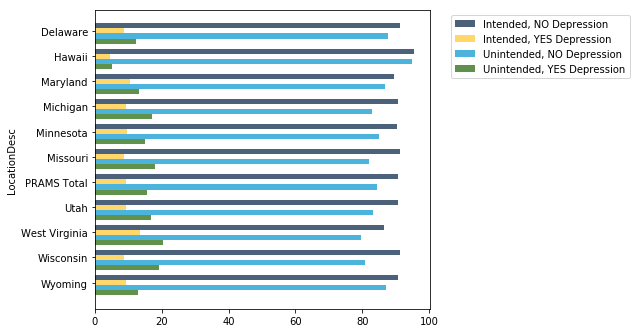

In [210]:
all_intentions.barh(0)

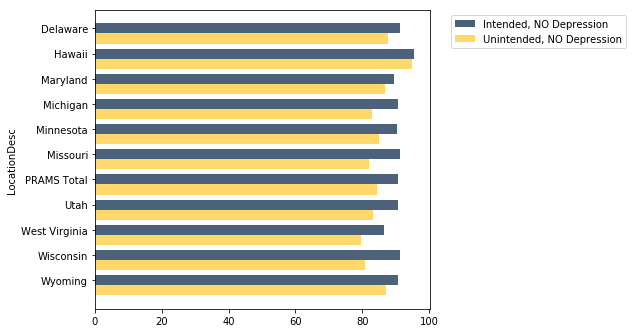

In [211]:
intentions_no = intended_no.join( "LocationDesc", unintended_no)
intentions_no.barh(0)

Women who did not have depression before pregnancy report similar rates of intentional and unintentional pregnancies across all states. 

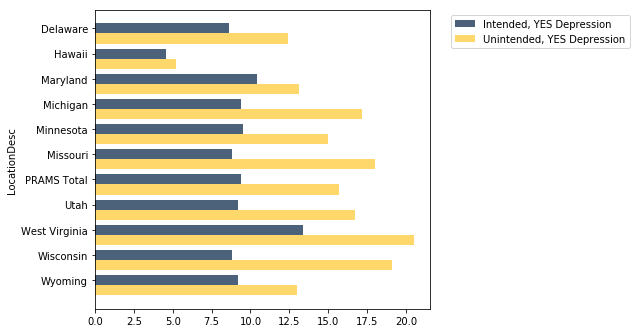

In [212]:
intentions_yes = intended_yes.join( "LocationDesc", unintended_yes)
intentions_yes.barh(0)

Women who did have depression before pregnancy show far higher percentages of unintentional pregnancy, particularly in West Virginia and Wisconsin.

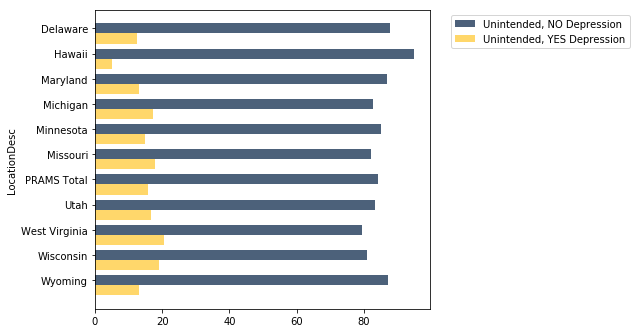

In [213]:
unintentional = unintended_no.join('LocationDesc', unintended_yes)
unintentional.barh(0)

Since the percentage of women who had depression was much smaller than the percentage of women without depression, when comparing all unintentional pregnancies the graph does not show much significance of mental health on unintentional pregnancies. 

In [214]:
avg = small1.pivot("Response", 'Break_Out', values="Data_Value", collect=np.average).drop('nan').where("Break_Out" != 'nan')

In [221]:
avg = avg.relabeled('NO', "NO Depression").relabeled( "YES", "YES Depression")

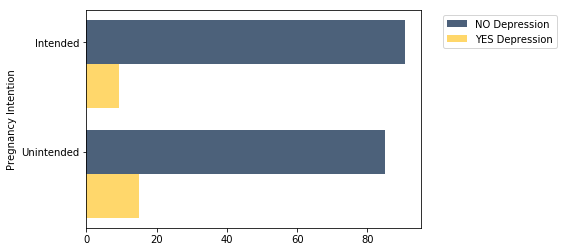

In [224]:
avg.relabeled('Break_Out', "Pregnancy Intention").barh('Pregnancy Intention')

In [232]:
another = small1.pivot("Break_Out", "Response", values="Data_Value", collect=np.average).drop('nan').where("Break_Out" != 'nan')

In [240]:
another = another.drop(0).with_column('Response', ['NO Depression', "YES Depression"])

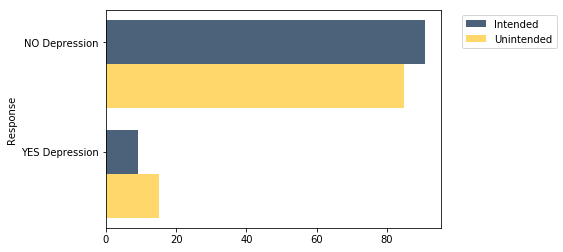

In [245]:
another.barh(2)

On average, women with depression are more likely ot have an unintentional pregnancy than an intentional pregnancy. 

#### QUESTION 3: 
How does birth control access for low income women compare in different states?

In [6]:
contraception = Table.from_df(pregnant[pregnant['Topic'] == 'Contraception - Conception'])

In [7]:
contraception.group('Question').column(0) #different questions asked about contraception usage

array(['(*PCH) Indicator of no birth control use at conception',
       '(*PCH) Indicator of no birth control use at conception for those not trying to get pregnant',
       'Indicator of contraception use at the time of pregnancy (for those not trying to get pregnant)',
       'Indicator of contraceptive use at time of pregnancy among women with an unintended pregnancy',
       'Reason for not using contraception at conception - had side effects from birth control',
       'Reason for not using contraception at conception - some other reason',
       'Reason for not using contraception at conception - thought she could not get pregnant at that time',
       'Reason for not using contraception at conception - thought she or partner was sterile',
       "Reason for not using contraception at conception- didn't mind getting pregnant",
       'Reason for not using contraception at conception- husband or partner did not want to',
       'Reason for not using contraception at conception- pr

In [51]:
birthcontrol_question = 'Reason for not using contraception at conception- problems getting birth control'
birthcontrol_rates = contraception.where(
    "Question", birthcontrol_question).where(
    "Response", "YES (CHECKED)").where(
    'Break_Out', '$10,000 to $24,999').select(
    'LocationDesc', 'LocationAbbr', "Data_Value").relabeled(
    1, "State").relabeled(2, "Percent")

In [52]:
df = birthcontrol_rates.to_df()
df.head()

,LocationDesc,State,Percent
0,Alaska,AK,9.2
1,Arkansas,AR,9.2
2,Colorado,CO,9.2
3,Delaware,DE,2.4
4,Georgia,GA,10.4


In [53]:
 df.sort_values(by=['Percent']).head() 

,LocationDesc,State,Percent
28,New York City,YC,2.0
3,Delaware,DE,2.4
25,Wisconsin,WI,2.7
5,Hawaii,HI,4.5
7,Maryland,MD,4.8


New York City has the lowest percent of low income women who report that their reason for not using contraception was lack of access to birth control, at only 2%. Delaware, Wisconsin, Hawaii, and Maryland also report similarly very low percantages.

In [54]:
df.sort_values(by=['Percent'], ascending=False).head()

,LocationDesc,State,Percent
20,Texas,TX,13.4
18,Pennsylvania,PA,12.2
9,Michigan,MI,11.9
12,Nebraska,NE,11.7
11,Missouri,MO,11.4


 Texas, Pennsaylvania, Michigan, Nebraska, and Missouri report that highest percentages of low income who do not use contraception because of lack of access to birthcontrol, all over 11%. 

#### Let's visualize this!

In [24]:
# US States GeoJSON file
us_states = os.path.join('data', 'us-states.json')
geo_json_data = json.load(open(us_states))
us_coords = [43, -100]

In [25]:
m = folium.Map(us_coords, zoom_start=4)

In [26]:
folium.GeoJson(geo_json_data
).add_to(m)

m

In [33]:
m.choropleth(
    geo_data=us_states,
    data=df,
    columns=['State', 'Percent'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Low Income Women with Access to Birth Control Issues(%)',
    highlight=True
)

m

#### Conclusions: 

This map reveals interesting things about this issue of lack of birthcontrol access for low income women. First of all, it is notable that almost half the states in the country fall into the lowest percentage bracket,meaning that low income do not report lack of access to birthcontrol being a reason why they do not use contraception. This could suggest that states like California, Nevada, Delaware, and Florida have made birthcontrol accessible to low income women. However, another possible explanation of these low percentages could be due to the attitudes of women in that state towards birthcontrol. A women's "reason" for not using contraception not be due to lack of access to birthcontrol but rather a religious or moral objection to birthcontrol. Hence, these states may be shaded similarly for very different reasons. This is a limitation to answering the question and comparing access to birth control for women in different states. 